# Zooming in on particular Grand datasets 

We use GLoVE vectors, they have worked best so far.

# The Grand category and feature to be illustrated

In [1]:
grand_category = "clothing"
grand_feature = "wealth"

randomseed = 3
how_many_pieces = 3
testfold = 0

# grand_category = "animals"
# grand_feature = "size"

# randomseed = 3
# how_many_pieces = 3
# testfold = 0

# Reading data

In [2]:
import os
from scipy import stats
import numpy as np 
import pandas as pd
import zipfile
import math
import sklearn
import torch
import torch.optim as optim
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import matplotlib.pyplot as plt

In [3]:
# GLoVE vectors

glove_path = "glove/glove.42B.300d.zip"
glove_file = "glove.42B.300d.txt"

feature_dim = 300

word_vectors = { }

with zipfile.ZipFile(glove_path) as azip:
    with azip.open(glove_file) as f:
        for line in f:
            values = line.split()
            word = values[0].decode()
            vector = np.array(values[1:], dtype=np.float32)
            word_vectors[word] = vector

In [4]:
grandratings_dir = "Grand_etal_csv/"
grandfeatures_path = "/Users/kee252/Data/grand_directions_in_space/features.xlsx"

grandfeatures_df = pd.read_excel(grandfeatures_path)

/Users/kee252/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [5]:
filename = grandratings_dir + grand_category + "_" + grand_feature + ".csv"

df = pd.read_csv(filename)
nspeakers = len(df.columns) -1
df["Average"] = [row.iloc[1:26].sum() / nspeakers for _, row in df.iterrows()]
# z-scores of average ratings
df["Gold"] = (df["Average"] - df["Average"].mean()) / df["Average"].std()

# obtain seed words from excel file
relevant_row = grandfeatures_df[grandfeatures_df.Dimension == grand_feature]
seedwords = relevant_row.iloc[:, 1:].values.flatten().tolist()
pos_seedwords = seedwords[:3]
neg_seedwords = seedwords[3:]

print(df.sort_values(by="Gold")[["Row", "Gold"]].head())
print(df.sort_values(by="Gold")[["Row", "Gold"]].tail())

           Row      Gold
29     sandals -1.927163
41  sweatshirt -1.601024
37    sneakers -1.425757
33      shorts -1.406011
17       jeans -1.355454
         Row      Gold
22  overcoat  1.308881
19   loafers  1.368797
14      gown  1.788911
44     tiara  2.505986
47    tuxedo  2.801108


# Train/test split



In [6]:


# split into training and test

rng = np.random.default_rng(seed = randomseed)
fold = rng.integers(low = 0, high = how_many_pieces, size = len(df.Gold))

test_indices =  [i for i in range(len(df.Gold)) if fold[i] == testfold]
print("Test datapoints")
for _, ell in df.iloc[ test_indices].iterrows():
    print("\t", ell["Row"], ell["Gold"])

Test datapoints
	 belt -0.7167842873257667
	 bikini -0.3787749703438325
	 blouse 0.26953882606205704
	 boots -0.6858059602174301
	 collar 0.3804484349040055
	 cuff 1.239034575222911
	 dress 0.377110178238551
	 gown 1.7889114785594675
	 hat -0.5372158261621659
	 knickers 0.3374966984655221
	 loafers 1.3687972906189365
	 robe 0.7040801752979442
	 shorts -1.4060112601913795
	 skirt -0.3007810337783011
	 stockings 0.6547279078018355
	 sweatshirt -1.6010241802549077
	 swimsuit -0.3229431762893026
	 tights -0.4056820285871001
	 trousers 0.4581597861784763
	 tuxedo 2.801108074904669
	 vest 0.9383148829929199


# Obtaining predictions

Train on train, predict on all, store results in the dataframe for seed-based and fit+s models.

In [7]:
# obtaining predictions for each datapoint
import eval_dim
import compute_dim
import statistics

# compute training and test data.
# we got test indices above
train_indices = [i for i in range(len(df.Gold)) if fold[i] != testfold]
all_thisdata_vectors = [word_vectors[ row.Row ] for row in df.itertuples() ]
gold_train = [ ell["Gold"] for _, ell in df.iloc[ train_indices ].iterrows()]
words_test =  [ell["Row"] for _, ell in df.iloc[ test_indices].iterrows()]
words_train = [ell["Row"] for _, ell in df.iloc[ train_indices].iterrows()]
vec_test =  [word_vectors[ w ] for w in words_test]
vec_train = [word_vectors[ w ] for w in words_train ]

random_seed = 123
hyper_offset = 1.0
hyper_jitter = False
hyper_average = True
hyper_alpha_s = 0.05

# seed-based dimension
seed_dimension = compute_dim.dimension_seedbased(pos_seedwords, neg_seedwords, word_vectors)
# df["Seed"] = compute_dim.predict_coord_fromtrain(vec_train, gold_train, dimension, all_thisdata_vectors)
df["Seed"] = compute_dim.predict_coord_fromtrain(all_thisdata_vectors, df.Gold, seed_dimension, all_thisdata_vectors)

# df["Seed"] = compute_dim.predict_scalarproj(all_thisdata_vectors, dimension)

# fit+s dimension
fit_dimension, fit_weight, fit_bias = compute_dim.dimension_fitted_fromratings_combined(vec_train, gold_train,
                                                                    300,
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = hyper_offset, 
                                                                    alpha = hyper_alpha_s,
                                                                    random_seed = random_seed)
df["Fit+s"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, fit_dimension, fit_weight, fit_bias)

In [8]:
testdf = df.iloc[ test_indices].copy()

# Ranking the datapoints, in comparison

In [9]:
# rankings of the datapoints
gold_wordrank = list(testdf.sort_values(by = "Gold").Row)
seed_wordrank = list(testdf.sort_values(by = "Seed").Row)
fits_wordrank = list(testdf.sort_values(by = "Fit+s").Row)

In [10]:
print("Rankings: Gold, Seed, Fit+s\n")
for i, word in enumerate(gold_wordrank):
    print(word,  "&", seed_wordrank[i], "&", fits_wordrank[i], '\\\\')

Rankings: Gold, Seed, Fit+s

sweatshirt & shorts & shorts \\
shorts & sweatshirt & boots \\
belt & belt & bikini \\
boots & blouse & tights \\
hat & boots & skirt \\
tights & swimsuit & swimsuit \\
bikini & skirt & stockings \\
swimsuit & trousers & trousers \\
skirt & bikini & loafers \\
blouse & robe & blouse \\
knickers & cuff & belt \\
dress & knickers & knickers \\
collar & hat & dress \\
trousers & collar & sweatshirt \\
stockings & vest & robe \\
robe & tights & collar \\
vest & loafers & cuff \\
cuff & stockings & vest \\
loafers & dress & hat \\
gown & gown & tuxedo \\
tuxedo & tuxedo & gown \\


In [11]:
# sort by square error
print("Datapoints, sorted by square error")
for column in ["Seed", "Fit+s"]:
    sqerr = (testdf.Gold - testdf[column])**2

    print(column)
    for se, word in sorted(zip(sqerr, testdf.Row)):
        print(word, se)
        
    print()

Datapoints, sorted by square error
Seed
blouse 0.0035638232696690347
belt 0.7878755402685886
swimsuit 2.1711541050664103
boots 2.5487977690230745
skirt 2.5989508395375855
sweatshirt 3.1592081188354064
robe 26.282846230135704
trousers 27.204419493196443
cuff 31.885058028973642
bikini 37.090520987543144
knickers 92.58788131405548
collar 122.48901263132508
shorts 131.75067532857986
hat 137.94126733393063
vest 144.8642227253415
tights 195.57719144432778
loafers 223.85816513326066
stockings 307.3790037055559
dress 368.6017039969853
gown 1550.2075047890594
tuxedo 1589.712871185585

Fit+s
collar 0.02537231914429187
shorts 0.05034434651336645
belt 0.11473051067252758
vest 0.11999637188938318
robe 0.12982362233208944
swimsuit 0.15648744225103137
tights 0.22716579571542383
dress 0.23810423553464657
skirt 0.2814212193862831
boots 0.2875513088770136
gown 0.3147363244456605
knickers 0.325922952988604
bikini 0.4137546486350342
cuff 0.46300391822628123
blouse 0.5216847345582759
trousers 0.99431750064

In [12]:
# sort datapoints by error in rank
print("Datapoints, by error in rank")
for column in ["Seed", "Fit+s"]:
    print(column, "\n")
    goldrank  = testdf.Gold.rank()
    modelrank = testdf[column].rank()
    sqdiff = (goldrank - modelrank)**2
    for sd, word in sorted(zip(sqdiff, testdf.Row)):
        print(word, sd)
    
    

Datapoints, by error in rank
Seed 

belt 0.0
gown 0.0
tuxedo 0.0
boots 1.0
collar 1.0
knickers 1.0
shorts 1.0
sweatshirt 1.0
bikini 4.0
loafers 4.0
skirt 4.0
swimsuit 4.0
vest 4.0
stockings 9.0
blouse 36.0
robe 36.0
trousers 36.0
cuff 49.0
dress 49.0
hat 64.0
tights 100.0
Fit+s 

blouse 0.0
cuff 1.0
dress 1.0
gown 1.0
knickers 1.0
robe 1.0
shorts 1.0
tuxedo 1.0
vest 1.0
boots 4.0
swimsuit 4.0
tights 4.0
collar 9.0
bikini 16.0
skirt 16.0
trousers 36.0
belt 64.0
stockings 64.0
loafers 100.0
sweatshirt 169.0
hat 196.0


# Plotting test vectors and interpretable dimensions in a 2-d image


In [13]:
# projection of a vector along a direction,
# where we want the actual vector, not its length
# (vec * direction1) * direction1
def vector_projection(vec, direction):
    dir_veclen = math.sqrt(np.dot(direction, direction))
    direction1 = direction / dir_veclen
    return np.dot(vec, direction1) * direction1

In [14]:

###
# Code for projecting embeddings down to 2-d
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

###
# function that produces a visualization of a given list of words.
# parameters
# - words: list of words to visualize
# - seeds_pos, seeds_neg: seedwords, which will also be visualized
# - space: dictionary mapping words to numpy arrays that are embeddings
# - lines: information about lines to add to the picture. This is a Python dictionary;
#   - key 'wordpairs': list of pairs of words: add lines between those words
#   - key 'dims': list of vectors that represent averaged interpretable dimensions.
#     For each dimension, project two words onto it, and draw a line through those two points
#   - key 'pointpairs': list of pairs of vectors: project into 2d space and draw a line through them
#   - key "colors": list of colors for the lines, one per line, first for word pairs lines,
#          then dims lines, then pointpairs lines
def visualize(words, seeds_pos, seeds_neg, space, lines, omitwords = []):
    # make the scatter plot
    allwords, twodim, pca_obj = plot_points(words, seeds_pos, seeds_neg, space, omitwords = omitwords)
    
    lineindex = 0
    
    # for every pair of words for which we want to draw
    # an individual-wordpair line: draw the line
    if "wordpairs" in lines:
        for word1, word2 in lines["wordpairs"]:
            i1 = allwords.index(word1)
            point1 = twodim[i1]
            i2 = allwords.index(word2)
            point2 = twodim[i2]
        
            if "colors" in lines:
                plt.axline(point1, point2, c=lines["colors"][lineindex])
            else:
                plt.axline(point1, point2)
                
            lineindex += 1
        
    # for every vector that is an averaged dimension:
    # project two words onto this vector to get two points, 
    # then draw a line through those two points.
    if "dims" in lines:
        for avgvector in lines["dims"]:
            # project the first two words onto the average vector
            # where we need the actual vector, not just its length
            proj1 = vector_projection(space[ words[0] ], avgvector)
            proj2 = vector_projection(space[ words[1] ], avgvector)
        
            # make them into an array to feed into pca
            x = np.array( [ proj1, proj2])
        
            # downproject to two dimensions
            points = pca_obj.transform(x)[:,:2]
        
            # and plot the line
            if "colors" in lines:
                plt.axline( points[0], points[1], c=lines["colors"][lineindex])
            else:
                plt.axline( points[0], points[1])
                
            lineindex += 1
            
    if "pointpairs" in lines: 
        for vec1, vec2 in lines["pointpairs"]:
            # downproject the two points
            x = np.array( [vec1, vec2 ])
            points = pca_obj.transform(x)[:, :2]
            
            # and plot
            if "colors" in lines:
                plt.axline( points[0], points[1], c = lines["colors"][lineindex])
            else:
                plt.axline(points[0], points[1])
                
            lineindex += 1
                
    plt.show()
        
    
def plot_points(words, seeds_pos, seeds_neg, space, omitwords = [ ]):
    allwords = words + seeds_pos + seeds_neg
    
    # put all the word vectors into one matrix
    word_vectors = np.array([space[w] for w in allwords])
    
    # use dimensionality reduction: 
    # Principal Component Analysis, PCA
    # keep the two first dimensions
    pca_obj = PCA()
    twodim = pca_obj.fit_transform(word_vectors)[:,:2]

    # set up the canvas
    plt.figure(figsize=(6,6))
    
    # plot colors: blue for concept words, 
    # green for positive seeds, red for negative seeds
    plotcolors = [ ]
    for w in allwords:
        if w in seeds_pos: plotcolors.append("g")
        elif w in seeds_neg: plotcolors.append("r")
        else: plotcolors.append("b")
    
    # add a scatter plot of the two-D embeddings
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', 
                c=plotcolors)

    # add each of the words to the plot, a bit above and to the right
    # of the 2-D dot it goes with
    for word, (x,y) in zip(allwords, twodim):
        if word not in omitwords:
            plt.text(x+0.05, y+0.05, word)

    return (allwords, twodim, pca_obj)
    # now show the canvas
    # plt.show()
    


### Seed-based dimension only

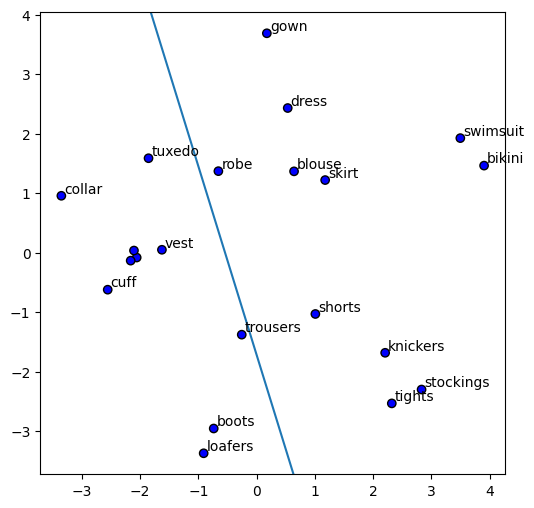

In [15]:
visualize(list(testdf["Row"]), [], [], word_vectors,  
          {"dims" : [seed_dimension]}, omitwords = ["sweatshirt", "belt", "hat"])

### Seed-based and fitted dimension

blue: seed based

red: fitted.

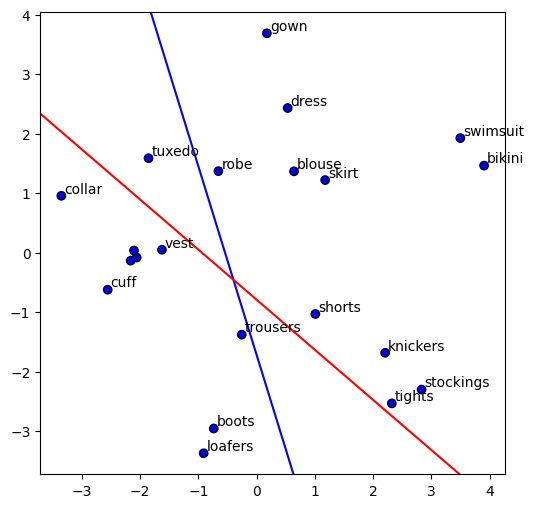

In [16]:
visualize(list(testdf["Row"]), [], [], word_vectors,  
          {"dims" : [seed_dimension], 
           "pointpairs" : [ (np.zeros(feature_dim), fit_dimension)],
          "colors" : ["b", "r"]}, 
          omitwords = ["sweatshirt", "belt", "hat"])

# Illustrating residuals

In [17]:
testdf.sort_values(by="Gold", inplace = True)

<AxesSubplot: xlabel='[Offset, Offset, Offset]', ylabel='[Gold, Seed, Fit+s]'>

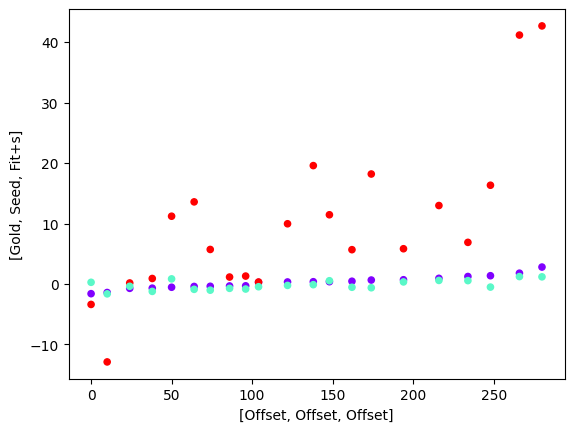

In [18]:
offset= []
nextoffset = 0
for  _, ell in df.iloc[ test_indices].iterrows():
    offset.append(nextoffset)
    nextoffset += 2 * len(ell["Row"]) + 2
    
testdf["Offset"] = offset
    
testdf.plot(kind = "scatter", y= ["Gold", "Seed", "Fit+s"], x = ["Offset", "Offset", "Offset"], 
            c = [0, 0.7, 0.3]*len(testdf.Gold), colormap = "rainbow")